In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import xgboost as xgb

Laoding and exploring the data


      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 e

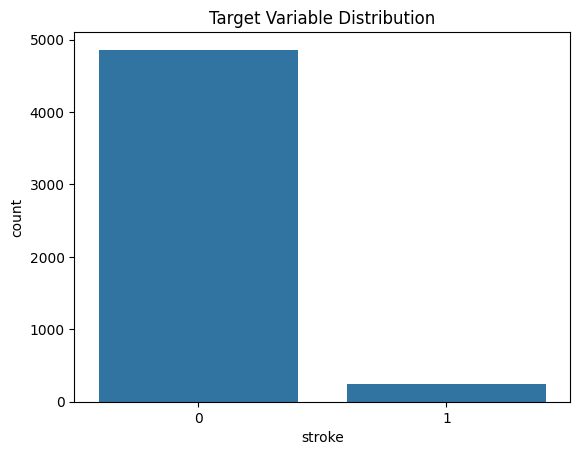

In [3]:
# Load the dataset
df = pd.read_csv('stroke-data.csv')  # Replace with your dataset path

# Quick overview of the dataset
print(df.head())
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Visualize target distribution
sns.countplot(x='stroke', data=df)
plt.title("Target Variable Distribution")
plt.show()

Data Quality analysis and cleaning

In [32]:
# Handle missing values (example: replacing missing BMI with the median)
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# Check for duplicates and drop if necessary
df.drop_duplicates(inplace=True)

# Ensure column names are correct (strip spaces if needed)
df.columns = df.columns.str.strip()
print("Columns after stripping spaces:", df.columns)

# Categorical features and numerical features
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical_features = ['age', 'avg_glucose_level', 'bmi']

# Check if all categorical features are present
missing_columns = [col for col in categorical_features if col not in df.columns]
if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    print("All categorical features are present.")

    # Encode categorical features using OneHotEncoder
    encoder = OneHotEncoder(drop='first', sparse_output=False)

    # Ensure that the columns exist before applying transformation
    if all(col in df.columns for col in categorical_features):
        encoded_cats = pd.DataFrame(encoder.fit_transform(df[categorical_features]), columns=encoder.get_feature_names_out(categorical_features))
        df = pd.concat([df.drop(categorical_features, axis=1), encoded_cats], axis=1)

        # Display the resulting DataFrame
        print(df.head())

Columns after stripping spaces: Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke', 'gender_Male', 'gender_Other', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')
Missing columns: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


Data Spliting

In [33]:
# Split the data into features and target
X = df.drop('stroke', axis=1)
y = df['stroke']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])


Model Training and Evaluation

In [34]:
# Initialize a Random Forest classifier
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Compute ROC-AUC score
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))


Accuracy: 0.949119373776908
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533

ROC-AUC Score: 0.8094970278920897


Model Optimization

In [35]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC-AUC Score:", grid_search.best_score_)

# Use the best model
best_model = grid_search.best_estimator_


Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best ROC-AUC Score: 0.8337388815168282


 Save the Model

In [38]:
import joblib

# Save the trained model
joblib.dump(best_model, 'stroke_model.pkl')

['stroke_model.pkl']

In [39]:
import joblib

# Save the scaler to a file
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [40]:
import joblib

# Save the encoder to a file
joblib.dump(encoder, "encoder.pkl")

['encoder.pkl']

Deployment Preparation

In [41]:
# Create a simple Gradio interface
import gradio as gr

def predict_stroke(gender, age, hypertension, heart_disease, ever_married, work_type,
                   Residence_type, avg_glucose_level, bmi, smoking_status):
    # Preprocess input
    input_data = pd.DataFrame({
        'gender': [gender],
        'age': [age],
        'hypertension': [hypertension],
        'heart_disease': [heart_disease],
        'ever_married': [ever_married],
        'work_type': [work_type],
        'Residence_type': [Residence_type],
        'avg_glucose_level': [avg_glucose_level],
        'bmi': [bmi],
        'smoking_status': [smoking_status]
    })

    # Apply preprocessing steps (use your pipeline or manual steps here)
    # Example for illustration:
    input_data[numerical_features] = scaler.transform(input_data[numerical_features])
    encoded_input = encoder.transform(input_data[categorical_features])

    # Predict using the model
    prediction = best_model.predict(encoded_input)
    return "Stroke" if prediction[0] == 1 else "No Stroke"

# Create Gradio app
interface = gr.Interface(
    fn=predict_stroke,
    inputs=[
        gr.Dropdown(['Male', 'Female', 'Other'], label="Gender"),
        gr.Slider(0, 100, label="Age"),
        gr.Checkbox(label="Hypertension"),
        gr.Checkbox(label="Heart Disease"),
        gr.Dropdown(['Yes', 'No'], label="Ever Married"),
        gr.Dropdown(['Private', 'Self-employed', 'Govt_job', 'Children'], label="Work Type"),
        gr.Dropdown(['Urban', 'Rural'], label="Residence Type"),
        gr.Number(label="Avg Glucose Level"),
        gr.Number(label="BMI"),
        gr.Dropdown(['Smokes', 'Never smoked', 'Formerly smoked'], label="Smoking Status")
    ],
    outputs=gr.Textbox(label="Prediction")
)


interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://02b19739c70786ba17.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
